In [1]:
import os
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from model_settings import ms
from plotters import PlotCols
import matplotlib.pyplot as plt

ms.find_root(Path())

# functions

In [2]:
def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

# loading model

In [3]:
root = os.path.join(ms.root)
models_dir = os.path.join(root,ms.trained_models)
models = pd.Series([f for f in os.listdir(models_dir) if not f.startswith('.') and f.find('Legacy')])
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024-11-09 112825652640 cboe spx relative asian
1     2024-11-09 124653897492 cboe spx relative barrier


In [4]:
selected_model = models.iloc[1]
model_dir = os.path.join(models_dir,selected_model)
pickle = [f for f in os.listdir(model_dir) if f.endswith('.pkl')][0]
picke_dir = os.path.join(model_dir,pickle)
model = joblib.load(picke_dir)
model

{'seed': 1312,
 'raw_data':          spot_price  strike_price  barrier  days_to_maturity updown outin  \
 0            1274.0        1146.6    637.0                60   Down   Out   
 1            1274.0        1146.6    637.0                60   Down   Out   
 2            1274.0        1146.6    637.0                60   Down    In   
 3            1274.0        1146.6    637.0                60   Down    In   
 4            1274.0        1146.6    637.0                90   Down   Out   
 ...             ...           ...      ...               ...    ...   ...   
 4067275      5857.0        6442.7   8785.5               540     Up    In   
 4067276      5857.0        6442.7   8785.5               720     Up   Out   
 4067277      5857.0        6442.7   8785.5               720     Up   Out   
 4067278      5857.0        6442.7   8785.5               720     Up    In   
 4067279      5857.0        6442.7   8785.5               720     Up    In   
 
             w barrier_type_name  r

In [5]:
print('model attributes:\n')
for k in model.keys():
    print(k)

model attributes:

seed
raw_data
dataset
target_name
excluded_features
numerical_features
categorical_features
feature_set
n_features
development_dates
test_dates
train_data
test_data
train_X
train_y
test_X
test_y
preprocessor
pipeline
model
model_fit
dnn_runtime
numerical_scaler
dnn_params
transformers
regressor
dnn_pipeline


In [6]:
unretrained = model['model']

In [7]:
for col in model['feature_set']:
    print(f"{col.replace("_"," ")}:",f"\n{model['test_data'][col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
print()

days to maturity: 
0     60
1     90
2    180
3    360
4    540
5    720
Name: days_to_maturity, dtype: int64

dividend rate: 
0       0.012624
1       0.012628
2       0.012641
3       0.012671
4       0.012687
          ...   
1152    0.023672
1153    0.023681
1154    0.023780
1155    0.023823
1156    0.024133
Name: dividend_rate, Length: 1157, dtype: float64

risk free rate: 
0      0.000330
1      0.000355
2      0.000380
3      0.000406
4      0.000431
         ...   
781    0.054494
782    0.054500
783    0.054513
784    0.054801
785    0.054889
Name: risk_free_rate, Length: 786, dtype: float64

theta: 
0       8.181674e-11
1       4.564269e-10
2       4.968155e-10
3       6.916618e-10
4       1.119760e-09
            ...     
1747    1.700398e+00
1748    1.732709e+00
1749    1.811241e+00
1750    1.836051e+00
1751    1.869788e+00
Name: theta, Length: 1752, dtype: float64

kappa: 
0       3.553361e-10
1       3.924365e-10
2       7.518568e-10
3       8.464905e-10
4       1.055398e

In [8]:
train_data = model['train_data'].copy()
test_data = model['test_data'].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'],format='mixed')
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'],format='mixed')
test_data = test_data.set_index('calculation_date').sort_index()
train_data = train_data.set_index('calculation_date').sort_index()
print(model['feature_set'])

['days_to_maturity', 'dividend_rate', 'risk_free_rate', 'theta', 'kappa', 'rho', 'eta', 'v0', 'relative_spot', 'relative_barrier', 'relative_rebate', 'w', 'barrier_type_name']


# retraining

In [9]:
from convsklearn import convsklearn
help(convsklearn)

Help on class convsklearn in module convsklearn.convsklearn:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  run_dnn(self, print_details=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object



In [10]:
test_dates = model['test_dates']
full_dataset = model['dataset']
pricename = [f[:f.find('_',0)] for f in full_dataset.columns if f.find('asian_price')!=-1 or f.find('barrier_price')!=-1][0]
all_dates = full_dataset['date'].drop_duplicates().sort_values().reset_index(drop=True)
all_dates = pd.to_datetime(all_dates,format='mixed')
# i = 0
# for date in all_dates:
#     i += 1
#     plt.scatter(date,i)

retraining_frequency = 20

n = model['test_dates'].shape[0]//retraining_frequency

In [11]:
cols = ['outofsample_MAE','outofsample_RMSE']
df = pd.DataFrame()

models = {}


for i in range(0,n):
    development_dates = pd.to_datetime(model['development_dates'],format='mixed')
    subset_test_dates = pd.to_datetime(model['test_dates'][(i*retraining_frequency):(i+1)*retraining_frequency],format='fixed')
    # print(f"training:  {min(development_dates).strftime('%A, %d %B, %Y')}  -  {max(development_dates).strftime('%A, %d %B, %Y')} ({len(development_dates)} trading days)")
    # print(f"testing:   {min(subset_test_dates).strftime('%A, %d %B, %Y')}  -  {max(subset_test_dates).strftime('%A, %d %B, %Y')} ({len(subset_test_dates)} trading days)")
    test_data = full_dataset[full_dataset['date'].isin(subset_test_dates)]

    target = test_data['relative_observed']
    prediction = unretrained.predict(test_data[model['feature_set']])
    error = prediction-target
    date = subset_test_dates.iloc[0]
    df.at[date,'outofsample_MAE'] = compute_MAE(error)
    df.at[date,'outofsample_RMSE'] = compute_RMSE(error)
    # print(df.dropna())
    # print('\n','%'*10,'\n')

df.index = pd.to_datetime(df.index)

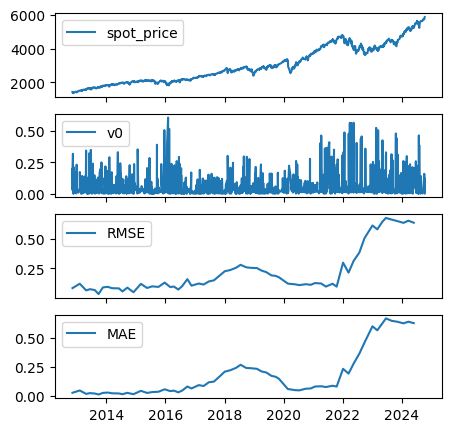

In [12]:
plotdf = model['test_data'][[
    'date','spot_price',
    # 'theta', 'kappa', 'rho', 'eta', 
    'v0'
]].copy().drop_duplicates().set_index('date')
fix,axs = plt.subplots(len(plotdf.columns)+2,figsize=(5,5),sharex=True)
for i,col in enumerate(plotdf.columns):
    axs[i].plot(plotdf[col],label=col)
    axs[i].legend()

axs[i+1].plot(df['outofsample_RMSE'],label='RMSE')
axs[i+1].legend()
axs[i+2].plot(df['outofsample_MAE'],label='MAE')
axs[i+2].legend()
plt.show()